In [1]:
import copy
import cv2
import imageio
import imutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
cv2.ocl.setUseOpenCL(False)

In [2]:
feature_extractor = 'brisk' # X sift, X surf, brisk, orb
feature_matching = 'bf' # bf, knn

In [3]:
images_directory = 'images\\'
results_directory = 'results\\'

for d in [images_directory, results_directory]:
    if not os.path.exists(d):
        os.makedirs(d)

In [4]:
def num_files(directory):
    return len(os.listdir(directory))

In [5]:
def plot_images(image_list, title_list, grid='off', file_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10))
    
    if len(image_list) == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)
    
    if file_name is not None:
        fig.savefig(results_directory + file_name)
        print('Image Plot Saved:', results_directory + file_name)

In [6]:
def save_image(image, file_name):
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    img.save(results_directory + file_name)
    print('Image Saved:', results_directory + file_name)

global_img.shape: (703, 352, 3)
add_img.shape: (631, 350, 3)


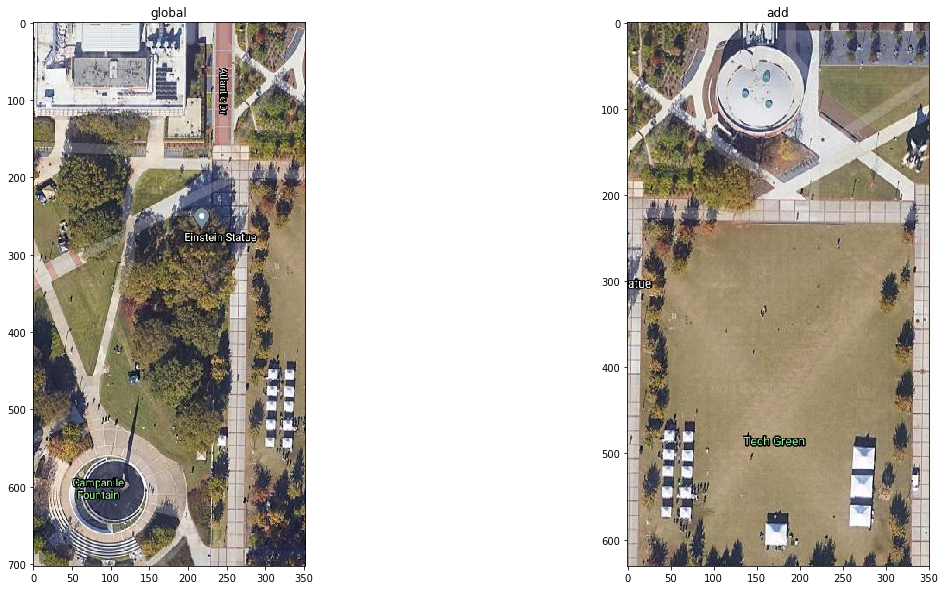

In [21]:
add_img = cv2.imread(images_directory + '1.png') # image to add on
global_img = cv2.imread(images_directory + '2.png') # previous image

image_list = [global_img, add_img]
title_list = ['global', 'add']
plot_images(image_list, title_list, grid='on')

print('global_img.shape:', global_img.shape)
print('add_img.shape:', add_img.shape)

In [22]:
def detectAndDescribe(image, method):
    # compute key points and feature descriptors
        
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [23]:
add_img_gray = cv2.cvtColor(add_img, cv2.COLOR_RGB2GRAY)
global_img_gray = cv2.cvtColor(global_img, cv2.COLOR_RGB2GRAY)

kp_global, features_global = detectAndDescribe(global_img_gray, method=feature_extractor)
kp_add, features_add = detectAndDescribe(add_img_gray, method=feature_extractor)

Number of global keypoints: 7007
Number of add keypoints: 3040


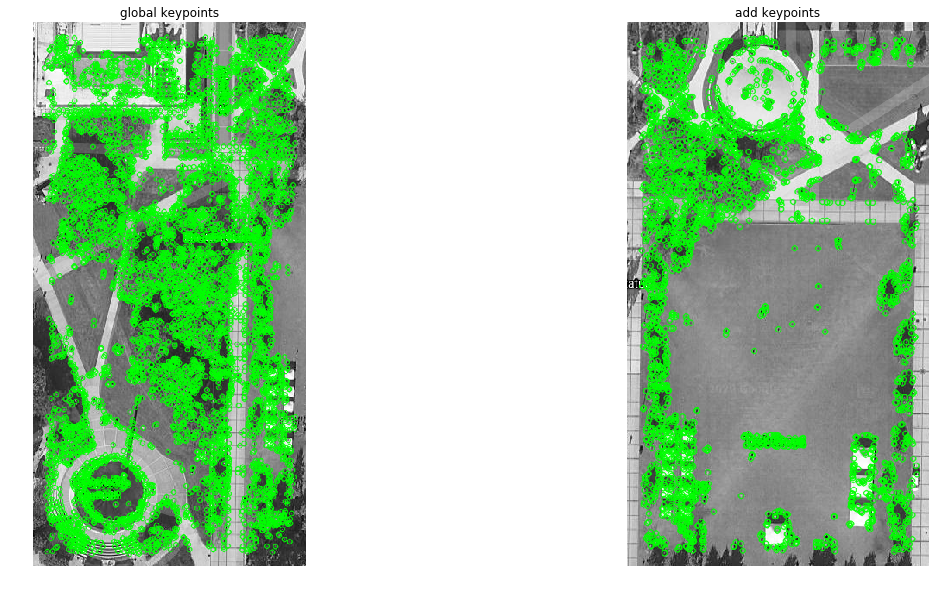

In [24]:
features_global_img = cv2.drawKeypoints(global_img_gray, kp_global, None, color=(0, 255, 0))
features_add_img = cv2.drawKeypoints(add_img_gray, kp_add, None, color=(0, 255, 0))

image_list = [features_global_img, features_add_img]
title_list = ['global keypoints', 'add keypoints']
plot_images(image_list, title_list)

print('Number of global keypoints:', len(kp_global))
print('Number of add keypoints:', len(kp_add))

In [25]:
def createMatcher(method, crossCheck):    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [26]:
def matchKeyPointsBF(features_global, features_add, method):
    bf = createMatcher(method, crossCheck=True) # cross check f1 closest to f2 and f2 closest to f1
    
    # Match descriptors.
    best_matches = bf.match(features_global, features_add)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches:", len(rawMatches))
    return rawMatches

In [27]:
def matchKeyPointsKNN(features_global, features_add, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(features_global, features_add, 2)
    print("Raw matches:", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Using: 'brisk' feature extractor
Using: 'bf' feature matcher
Raw matches: 1559


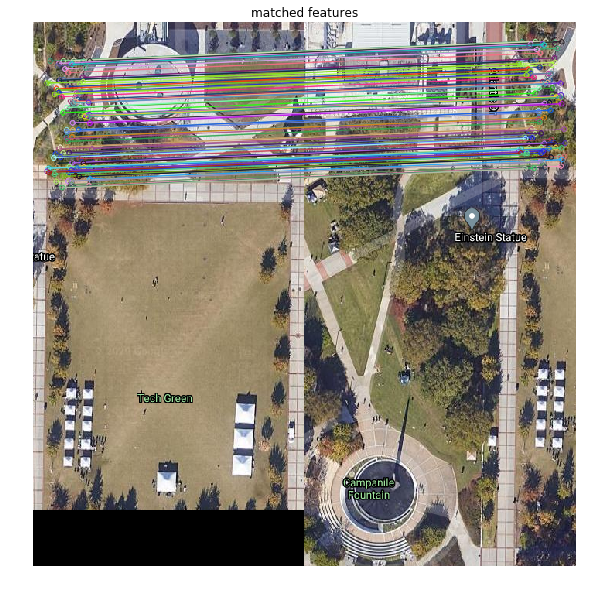

In [28]:
print("Using: '{}' feature extractor".format(feature_extractor))
print("Using: '{}' feature matcher".format(feature_matching))

MIN_NUM_MATCHES_TO_DISPLAY = 100

if feature_matching == 'bf':
    matches = matchKeyPointsBF(features_add, features_global, method=feature_extractor)
    matched_features_img = cv2.drawMatches(add_img, kp_add, global_img, kp_global, matches[:np.min([MIN_NUM_MATCHES_TO_DISPLAY, len(matches)])], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(features_add, features_global, ratio=0.75, method=feature_extractor)
    matched_features_img = cv2.drawMatches(add_img, kp_add, global_img, kp_global, np.random.choice(matches, np.min([MIN_NUM_MATCHES_TO_DISPLAY, len(matches)])), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

image_list = [matched_features_img]
title_list = ['matched features']
plot_images(image_list, title_list)

In [ ]:
def getHomography(kp_add, kp_global, features_add, features_global, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kp_add = np.float32([kp.pt for kp in kp_add])
    kp_global = np.float32([kp.pt for kp in kp_global])
    
    if len(matches) > 4:

        # construct the two sets of points
        pts_add = np.float32([kp_add[m.queryIdx] for m in matches])
        pts_global = np.float32([kp_global[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(pts_add, pts_global, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
M = getHomography(kp_add, kp_global, features_add, features_global, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

In [ ]:
from matplotlib.path import Path

def determine_polygon_mask(corners, height, width):
    #determine height and width of mask
#     width = np.max([c[0] for c in corners]) - np.min([c[0] for c in corners]) + 1
#     height = np.max([c[1] for c in corners]) - np.min([c[1] for c in corners]) + 1
    
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    x, y = x.flatten(), y.flatten()
    
    points = np.vstack((x, y)).T
    
    path = Path(corners)
    grid = path.contains_points(points)
    grid = grid.reshape((height, width))
    
    return grid

In [ ]:
#max possible images size
updated_width = add_img.shape[1] + global_img.shape[1]
updated_height = add_img.shape[0] + global_img.shape[0]

updated_add_img = cv2.warpPerspective(add_img, H, (updated_width, updated_height)) # place added image in scene 

updated_img = np.zeros((updated_width, updated_height, 3))
updated_img[0:global_img.shape[0], 0:global_img.shape[1], :] = global_img # place global in top left corner

gray_img = cv2.cvtColor(copy.deepcopy(updated_add_img), cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)[1]

contours = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

c = max(contours, key=cv2.contourArea) # choose countour corners that create largest area
# corners = [tuple(corner[0]) for corner in c] # turn into tuple list

(x, y, w, h) = cv2.boundingRect(c)
cropped_updated_add_img = copy.deepcopy(updated_add_img)

print(updated_img.shape)
print(cropped_updated_add_img.shape)

updated_img[y:y+h, x:x+w] = cropped_updated_add_img[y:y+h, x:x+w]
updated_img = updated_img.astype(np.uint8)

# image_list = [add_img, updated_add_img, gray_img, thresh_img, updated_img]
# title_list = ['add', 'updated add', 'gray', 'thresh', 'updated']
# plot_images(image_list, title_list, grid='on')
# print('updated_img.shape:', updated_img.shape)

In [ ]:
# transform the panorama image to grayscale and threshold it 
gray_img = cv2.cvtColor(copy.deepcopy(updated_img), cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)[1]

print('updated_img.shape', updated_img.shape)
print('gray_img.shape:', gray_img.shape)
print('thresh_img.shape:', thresh_img.shape)

contours = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

c = max(contours, key=cv2.contourArea) # choose countour corners that create largest area
corners = [tuple(corner[0]) for corner in c] # turn into tuple list
print('maximum area corners:', corners)

(x, y, w, h) = cv2.boundingRect(c)
result = copy.deepcopy(updated_img)
result = result[y:y+h, x:x+w]

print('result.shape:', result.shape)

image_list = [updated_img, gray_img, thresh_img]
title_list = ['updated','gray', 'threshold']
plot_images(image_list, title_list, grid='on')

image_list = [result]
title_list = []
plot_images(image_list, title_list, grid='off')

save_image(result, 'combo_'+str(num_files(results_directory))+'.png')

In [ ]:
# def cropper(result):
#     # transform the panorama image to grayscale and threshold it 
#     gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
#     thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

#     # Finds contours from the binary image
#     contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     contours = imutils.grab_contours(contours)

#     # get the maximum contour area
#     c = max(contours, key=cv2.contourArea)

#     # get a bbox from the contour area
#     (x, y, w, h) = cv2.boundingRect(c)

#     # crop the image to the bbox coordinates
#     result = result[y:y + h, x:x + w]
#     return result, (x, y, w, h)

In [ ]:


# # Apply panorama correction
# width = add_img.shape[1] + global_img.shape[1]
# height = add_img.shape[0] + global_img.shape[0]

# # goal = np.zeros((height, width, 4))

# result = cv2.warpPerspective(add_img, H, (width, height)) # warps the training image into position
# # cropped, (xstart, ystart, ww, hh) = cropper(result)


# # result[0:global_img.shape[0], 0:global_img.shape[1]] = global_img # place the query image
# # goal[ystart:ystart+hh, xstart:xstart+ww] = cropped

# # goal = goal.astype(np.uint8)

# #place subsection over top because it will be a full image. if placing previous stitch on top it could have blank sections that block out previous

# plt.figure(figsize=(20,10))
# plt.imshow(goal)

# plt.axis('off')
# plt.show()
# print(goal.shape)
